# CERN Open Data: Higgs ML Challenge
## Sample Tutorial for *ABSOLUTE BEGINNERS* using small-sized datasets
### PART III: The Machine Learning Challenge

For this tutorial, we'll play with the ATLAS Higgs Machine Learning Challenge Dataset. 
The [page](http://opendata.cern.ch/record/328) has a clear description of the file and it describes nicely how the data was obtained. 

###### Note: 
Install ROOT on OSX with these [instructions](https://alexpearce.me/2016/02/root-on-os-x-el-capitan/). For a similar tutorial, check out http://betatim.github.io/posts/sklearn-for-TMVA-users/. 

In [2]:
import pandas as pd 
import csv 
import numpy as np

### Input File
Download the csv file and convert into a dataframe. 

In [26]:
df = pd.read_csv("/Users/up/Downloads/atlas-higgs-challenge-2014-v2.csv")
df.head() #Take a look at the first 5 entries

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


In [4]:
df.info() #take a look at the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818238 entries, 0 to 818237
Data columns (total 35 columns):
EventId                        818238 non-null int64
DER_mass_MMC                   818238 non-null float64
DER_mass_transverse_met_lep    818238 non-null float64
DER_mass_vis                   818238 non-null float64
DER_pt_h                       818238 non-null float64
DER_deltaeta_jet_jet           818238 non-null float64
DER_mass_jet_jet               818238 non-null float64
DER_prodeta_jet_jet            818238 non-null float64
DER_deltar_tau_lep             818238 non-null float64
DER_pt_tot                     818238 non-null float64
DER_sum_pt                     818238 non-null float64
DER_pt_ratio_lep_tau           818238 non-null float64
DER_met_phi_centrality         818238 non-null float64
DER_lep_eta_centrality         818238 non-null float64
PRI_tau_pt                     818238 non-null float64
PRI_tau_eta                    818238 non-null float64
PRI_tau_phi

# A little background on the *Background*
Only three background processes were kept for the Challenge to simplify things. From the documentation these are: 
- the decay of the Z boson (with a mass of 91.2 GeV) into two taus
- events with a pair of top quarks, which can have a lepton and a hadronic tau among their decay
- the decay of the W boson, where one electron or muon and a hadronic tau can appear simultaneously only through imperfections of the particle identification procedure. 

See [page](http://opendata.cern.ch/record/328) for more details. 

## How can we play with the dataset? 

There's a [pdf](http://opendata.cern.ch/record/329) describing how we can play with the dataset. We can also follow, [Tim Head's tutorial](http://betatim.github.io/posts/sklearn-for-TMVA-users/). Read about the Kaggle challenge [here](http://proceedings.mlr.press/v42/cowa14.pdf) and the [winning solution](http://proceedings.mlr.press/v42/meli14.pdf). 

Let's look at some variables and plot them. Note that these are mixed instances of background and signal. 

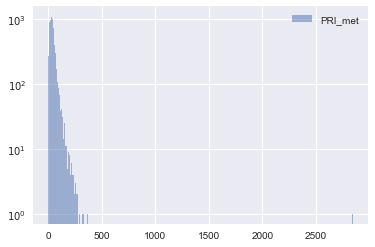

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # cosmetics
%matplotlib inline
plt.hist(df.PRI_met[:10000], bins=500, alpha=0.5, label='PRI_met' )
plt.legend()
plt.gca().set_yscale("log")
plt.show()

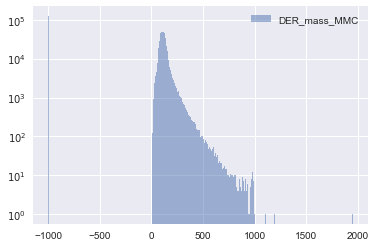

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # cosmetics
%matplotlib inline
plt.hist(df.DER_mass_MMC, bins=500, alpha=0.5, label='DER_mass_MMC')
plt.grid(True)
plt.legend()
plt.gca().set_yscale("log")
plt.show()

## Pre-processing

First we're going to have to remove some columns that we won't use as input to the classifier. You can read more about it in the [pdf documentation](http://opendata.cern.ch/record/329). We'll also have to do two things to facilitate the learning process:
- replace the label signal = 's' and background = 'b' with 0s nd 1s, respectively and, 
- normalize the data so that learning would be faster. 

*"Learning progresses much faster if the input values are centered at zero with unit variance. Moreover, because of the vastly different scales in the inputs, learning does not progress at all unless we do so."* -MAndrews

In [27]:
#Replace signal and background labels with 1s and 0s
df['Label'] = df['Label'].map({'s':0 , 'b':1})
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,0,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,1,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,1,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,1,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,1,t,6.245333


In [11]:
exclude = ['Events', 'Weight', 'Label', 'KaggleSet', 'KaggleWeight']
trainData = df.loc[:, df.columns.difference(exclude)] 

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trainData[trainData.columns] = scaler.fit_transform(trainData[trainData.columns])
trainData.head()

,DER_deltaeta_jet_jet,DER_deltar_tau_lep,DER_lep_eta_centrality,DER_mass_MMC,DER_mass_jet_jet,DER_mass_transverse_met_lep,DER_mass_vis,DER_met_phi_centrality,DER_prodeta_jet_jet,DER_pt_h,...,PRI_jet_subleading_pt,PRI_lep_eta,PRI_lep_phi,PRI_lep_pt,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_tau_eta,PRI_tau_phi,PRI_tau_pt
0,1.558181,0.883789,1.560901,0.461169,1.100465,0.067902,0.411171,1.275526,1.569166,-0.471040,...,1.535972,1.812996,-1.357205,0.222812,-0.764108,-0.148047,0.384999,0.847675,0.217038,-0.270193
1,-0.640420,1.407561,-0.640422,0.516490,-0.605427,0.551613,0.544430,1.290599,-0.640416,-0.153024,...,-0.639996,0.411374,0.029497,-0.441436,0.093841,-1.052222,-0.357703,1.689860,-1.650719,0.147838
2,-0.640420,0.991361,-0.640422,-2.339666,-0.605427,3.191741,1.104226,1.290599,-0.640416,-0.350321,...,-0.639996,-0.738715,0.552334,3.374379,0.388615,-1.201171,0.398254,-0.571348,-1.145236,-0.291772
3,-0.640420,1.198820,-0.640422,0.474552,-0.605427,0.909146,-0.004868,-0.969427,-0.640416,-0.905753,...,-0.639996,-0.397802,-1.735147,0.299363,-0.325348,0.037863,-0.976581,-1.354201,0.012752,-0.715643
4,-0.640420,1.942858,-0.640422,0.553245,-0.605427,-0.914048,1.322348,-1.053163,-0.640416,-0.653576,...,-0.639996,0.646296,0.837167,-0.764076,-1.198037,-0.475735,-1.236256,-1.800839,-1.221223,-0.467660


## Splitting the dataset into training and validation sets
We then split our dataset into training and validation sets. A good [rule of thumb](https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio) is to split into 80/20 training and testing (or a cross-validation) set. However a test set with 100000 would be good enough. We'll use scikit-learn's train_test_split function to do this. 

Recall that the **trainData** DataFrame has already excluded the labels and other non-inputs to the classifier. It contains all the other features that will help us discriminate between signal and background. We'll put in as first argument, trainData into the **train_test_split** function. The second argument would be the label for each instance. This tells whether the event is signal (0) or background (1). 

In [29]:
from sklearn.cross_validation import train_test_split
rawXtrain, rawXcv, ytrain, ycv = train_test_split(trainData, df.Label, random_state=1, test_size=100000)

Let's see if our dataset split properly. There should be 100,000 instances for our testing set. The training set with the labels will be sort of *memorized* by our classifier and will be used to classify new and unfamiliar instances into signal and background. 

In [30]:
# Print the shapes of both sets.
print(rawXtrain.shape)
print(rawXcv.shape)
print(ytrain.shape)
print(ycv.shape)

(718238, 31)
(100000, 31)
(718238,)
(100000,)


# The Training

We can use several algorithms or classifiers for this project. For now, we'll be using the *Gradient Boosting Classifier*. 

In [31]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
import math
gbc = GBC(n_estimators=50, max_depth=5,min_samples_leaf=200,max_features=10,verbose=1)
gbc.fit(rawXtrain,ytrain)

      Iter       Train Loss   Remaining Time 
         1           1.2171            4.45m
         2           1.1621            4.17m
         3           1.1127            4.09m
         4           1.0686            4.06m
         5           1.0399            4.13m
         6           1.0092            4.02m
         7           0.9816            3.93m
         8           0.9570            3.90m
         9           0.9363            3.83m
        10           0.9181            3.79m
        20           0.8196            2.74m
        30           0.7782            1.79m
        40           0.7582           52.91s
        50           0.7455            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=10, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=200,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=50, presort='auto', random_state=None,
              subsample=1.0, verbose=1, warm_start=False)

We can visualize the discriminatory power of one feature, for instance, the variable *DER_mass_MMC*. 

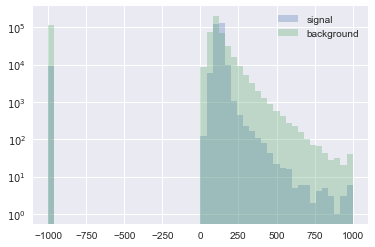

In [39]:
#split Dataframe according to signal and background 
import pandas.core.common as com
from pandas.core.index import Index

from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # cosmetics
%matplotlib inline

plt.hist(df[df.Label==0].DER_mass_MMC, alpha=.3, bins=50, range=[-1000,1000], label ="signal")
plt.hist(df[df.Label==1].DER_mass_MMC, alpha=.3, bins=50, range=[-1000,1000], label ="background")
plt.gca().set_yscale("log") #set to logscale
plt.legend()
plt.show()

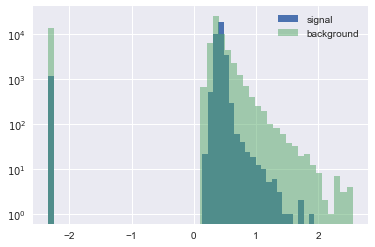

In [42]:
#or we could do it like this with the training data (notice less events)
variableToPlot='DER_mass_MMC'
plt.hist(rawXcv[ycv == 0][variableToPlot], bins=50, alpha=1, label='signal');
plt.hist(rawXcv[ycv == 1][variableToPlot], bins=50, alpha=0.5, label='background');
#plt.hist(rawXcv[(testPrediction != ycv) & (ycv == 0)][variableToPlot], bins=50, alpha=1, label='Quarks (misidentified)');
plt.gca().set_yscale("log")
#plt.ylabel('Radial')
plt.legend();

## Evaluating Classifier Performance
### ROC AUC
First we plot the [ROC curve](https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/). The ROC (Receiver Operator Characteristic) is usually used to visualize the performance of a classifier  
As you can see here, the area under the curve is 0.81. If you get zero where your curve coincides with the dashed line, then you're classifier has failed.   


CV ROC AUC: 0.805487220135


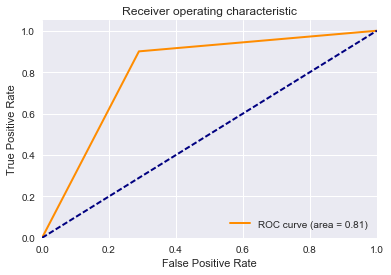

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc

y_predict = gbc.predict(rawXcv) 
from sklearn.preprocessing import LabelEncoder
class_labels = LabelEncoder()
prediction_le = class_labels.fit_transform(y_predict)

fpr, tpr, thresholds = roc_curve(ycv,y_predict)
#fpr, tpr false pos and true pos
#print ycv.shape
#print ycv
#print y_predict
import numpy as np
ycvarray = np.asarray(ycv)
#print ycvarray

roc_auc = auc(fpr,tpr) 
print "CV ROC AUC:",roc_auc

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix 
A [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/), in this case for a binary classifier, is a way to tabulate the misclassified items. 

From the matrix below, we know that there are two possible classes, *signal* = 0 and *background* = 1. 
Here the classifier predicted 24392 + 6550 = 30942 to be signal and 9929+59129 = 69068 to be background. 
However, real total number of signal instances is 34321 while real signal instances as 65679. Not bad at all. 

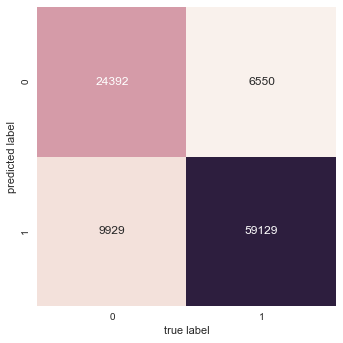

In [44]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

#testPrediction = model.predict_classes(Xcv, verbose=0)
#testPrediction = testPrediction.flatten()

y_predict = y_predict.flatten()

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ycv, y_predict)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
#                xticklabels=testLabels, yticklabels=testLabels)
plt.xlabel('true label')
plt.ylabel('predicted label');